In [1]:
import argparse, requests, re
import html
import pandas as pd
from os.path import join, isdir
import numpy as np

## Query AFND to get population frequencies 

In this notebook we query and clean the AFND data (per locus) with following steps:

1. We query the AFND: http://www.allelefrequencies.net/ using the basic AFND API given [here](http://www.allelefrequencies.net/extaccess.asp)
2. We format the allele codes according to the standard nomenclature (bellow). We keep the alleles which contain the _allele group_ and the _specific HLA protein_ fields.
3. We map the populations to countries.
4. We remove the duplicate entries for "population"-"allele" pairs.
5. We perform sanity checks on the data (we make sure that the allele frequencies per population add up to 1)
    - if they add up to less than 0.9 or more than 1.1, we consider the entry for the population invalid
    - if the frequencies don't add up to 1, but are within the [0.9-1.1] range, we consider this a marginal error and we rescale the frequencies

**Output:** As the output of this notebook you will find the csv files `AFND_data_locus_*.csv` containing the population frequencies of different alleles across the chosen loci. 
 
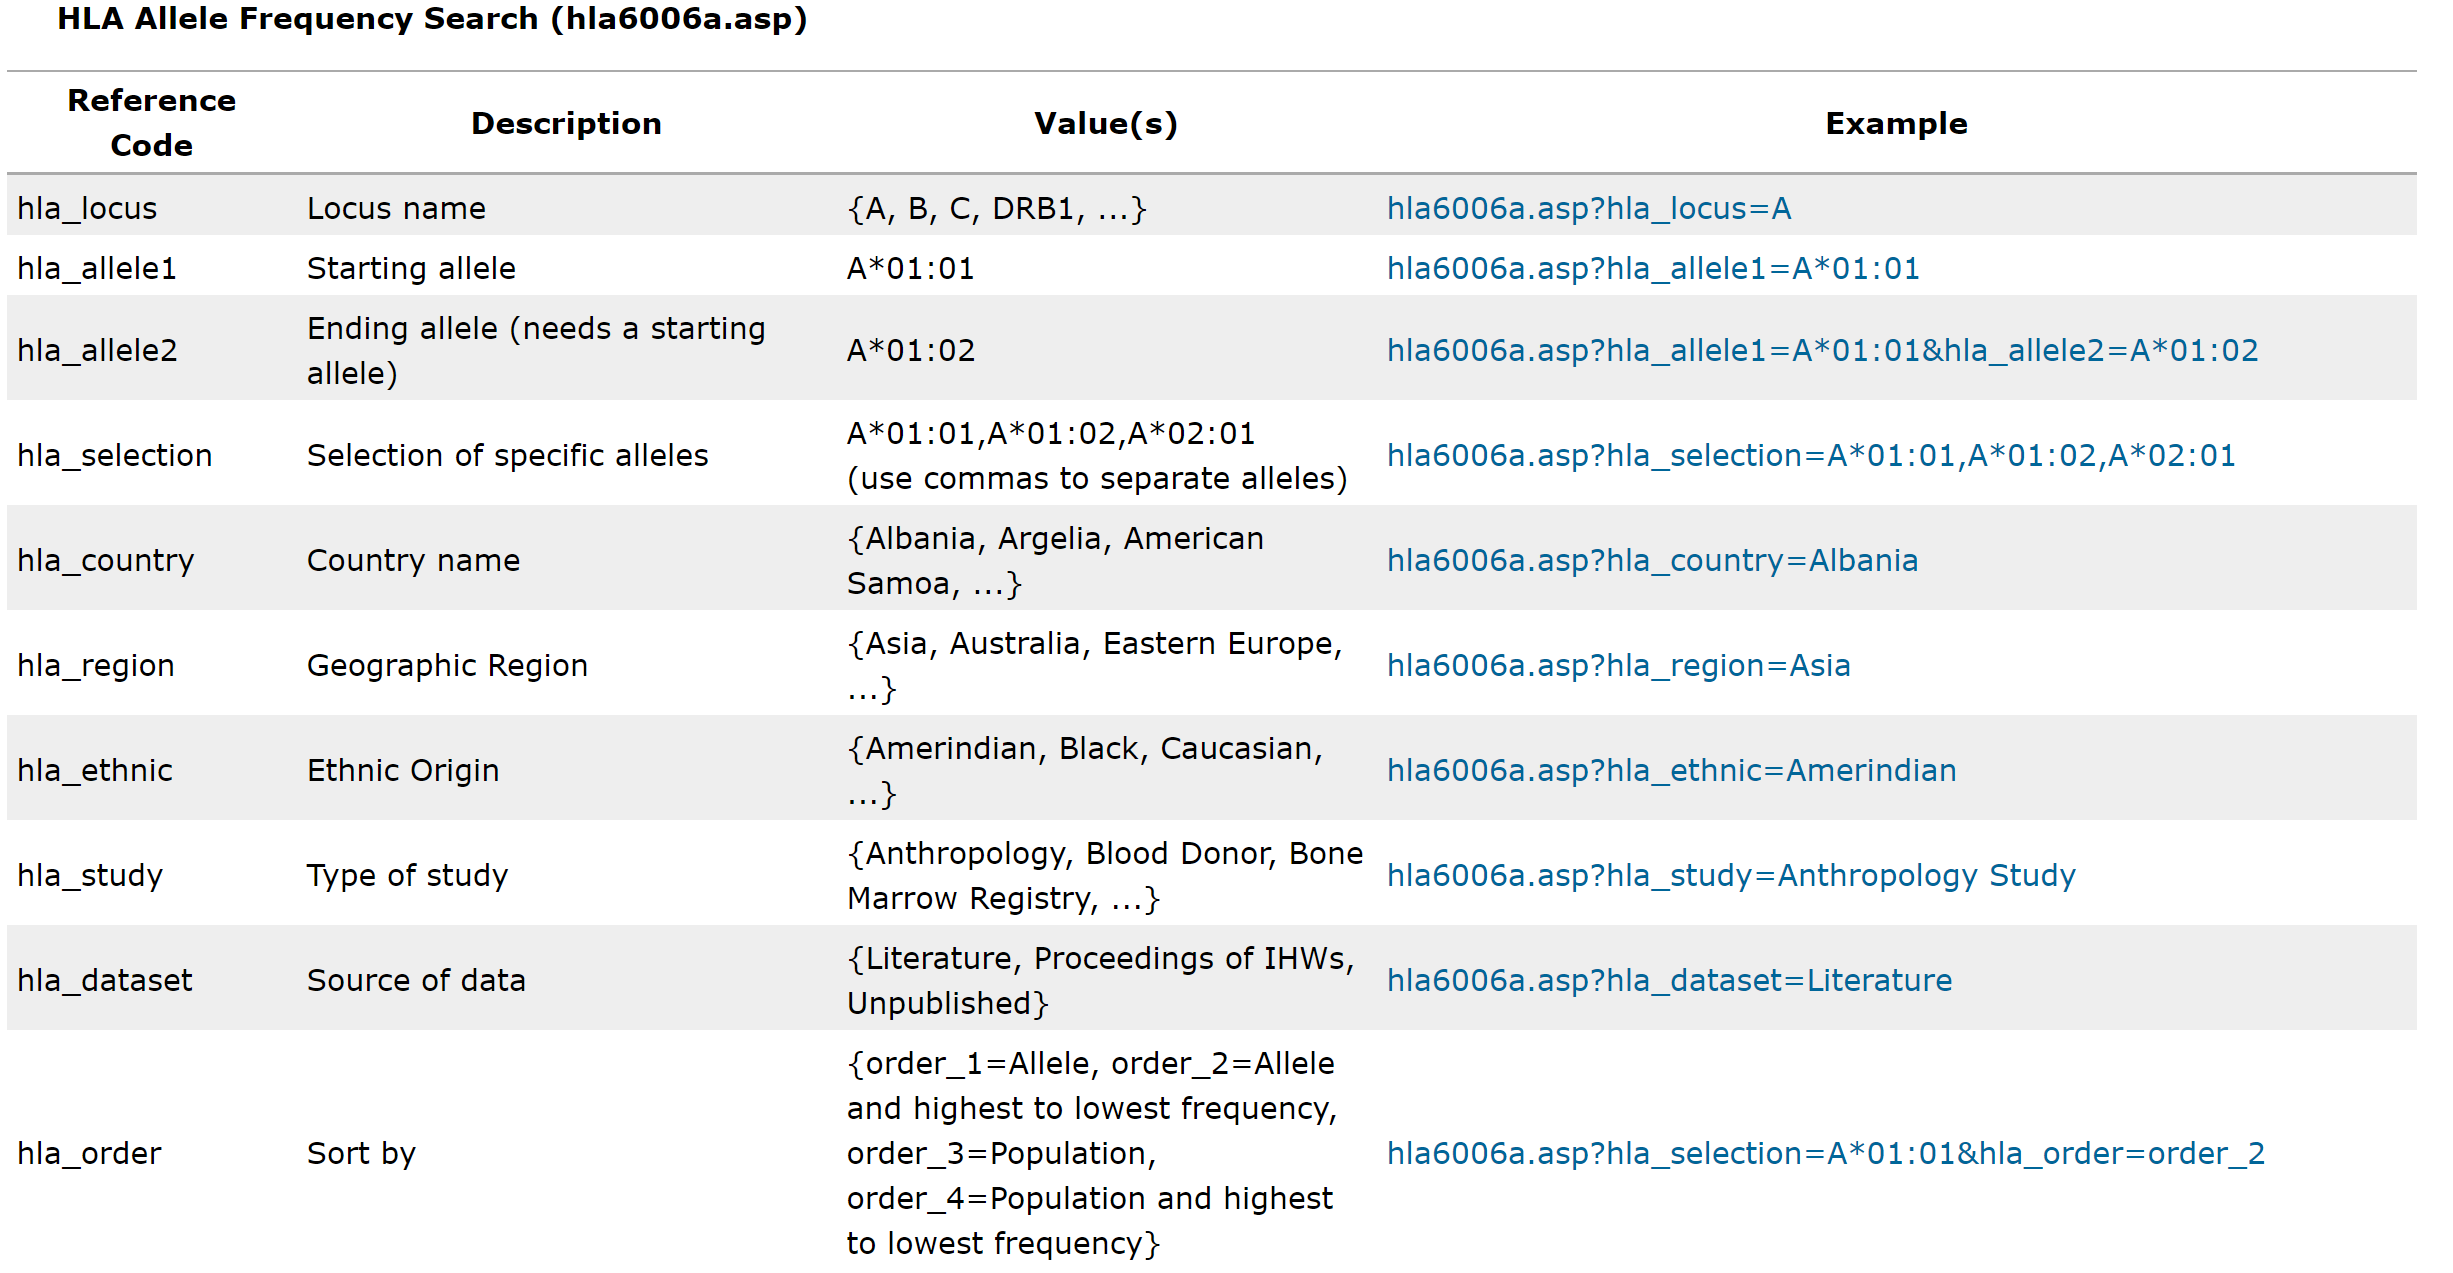

Remember the nomenclature from [here](http://hla.alleles.org/nomenclature/naming.html)

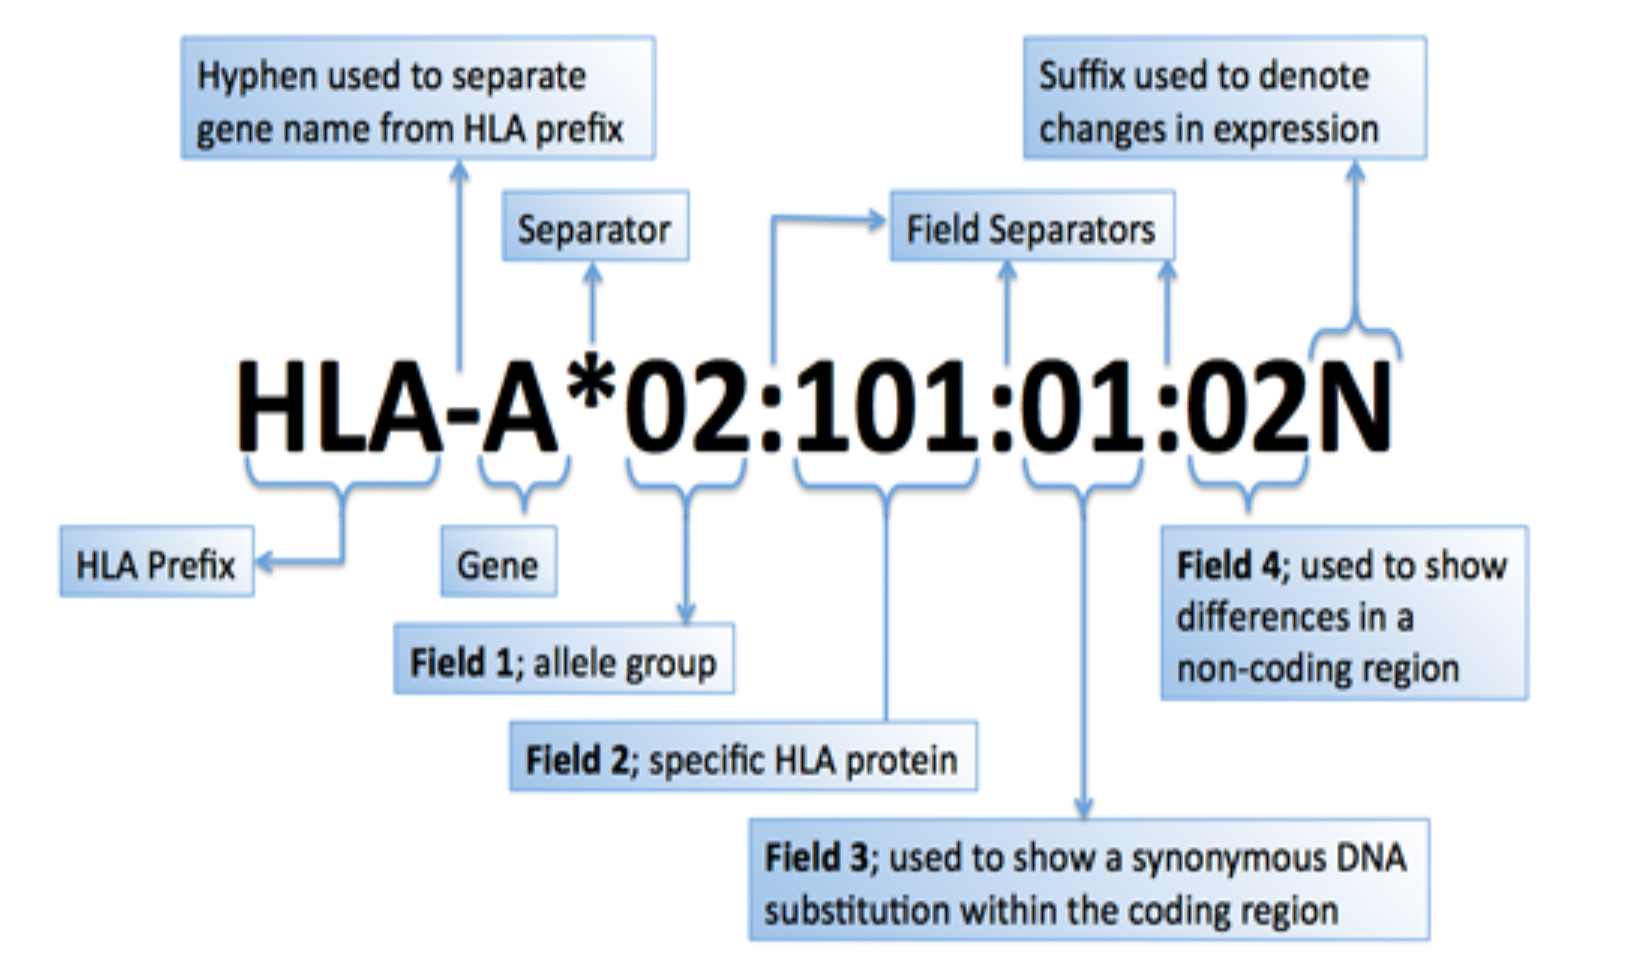

## Step 1 - Fetch all the data for the locus

Choose the locus and download the related the data

In [3]:
# the API base URL
frequencyURL = 'http://www.allelefrequencies.net/hla6006a_scr.asp'
# locus searched for - change to A/B/C
locus = "C" 
# allele group range (to query group by group)
first_allele_group = 1
last_allele_group = 90

Query the AFND one locus and one allele group at a time (be careful with this because if the query returns has more than 10,000 points to return, the output will be truncated). 

In [39]:
full_df = None

for group in range(first_allele_group, last_allele_group):
    hla_allele1 = locus+"*{:02}".format(group)
    print("Retrieving results for groups from {}-{}".format(hla_allele1, hla_allele1))
    #funfact when selecting from A*01-A*01 we get all A*01
    url_query = frequencyURL+"?hla_locus={}".format(locus)+"&hla_allele1={}&hla_allele2={}".format(hla_allele1, hla_allele1)
    response = requests.get(url_query)
    print(f'Frequencies succesfully retrieved from {response.url}')
    
    df = pd.read_html(response.text, attrs={'class':'tblNormal'})[0]
    df.drop(columns='Line', inplace=True)
    if len(df) == 10000:
        print("WARNING: for group {} retrieved exactly 10,000 back - could have been chopped - maybe download again!".format(group))
    if full_df is None:
        full_df = df
    else:
        full_df = pd.concat([full_df, df])

Retrieving results for groups from C*01-C*01
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*01&hla_allele2=C*01
Retrieving results for groups from C*02-C*02
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*02&hla_allele2=C*02
Retrieving results for groups from C*03-C*03
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*03&hla_allele2=C*03
Retrieving results for groups from C*04-C*04
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*04&hla_allele2=C*04
Retrieving results for groups from C*05-C*05
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*05&hla_allele2=C*05
Retrieving results for groups from C*06-C*06
Frequencies succesfully retrieved from http://www.allel

Retrieving results for groups from C*48-C*48
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*48&hla_allele2=C*48
Retrieving results for groups from C*49-C*49
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*49&hla_allele2=C*49
Retrieving results for groups from C*50-C*50
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*50&hla_allele2=C*50
Retrieving results for groups from C*51-C*51
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*51&hla_allele2=C*51
Retrieving results for groups from C*52-C*52
Frequencies succesfully retrieved from http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=C&hla_allele1=C*52&hla_allele2=C*52
Retrieving results for groups from C*53-C*53
Frequencies succesfully retrieved from http://www.allel

In [40]:
full_df

,Allele,Population,% of individuals that have the allele,Allele Frequency,Sample Size,Location
0,C*01,Albania,NaN,0.0380,160,41_0_N_20_0_E
1,C*01,Albania pop 2,7.6,0.0382,432,41_9_N_20_10_E
2,C*01,Albanian Kosovo,NaN,0.0792,120,41_50_N_20_1_E
3,C*01,Algeria pop 2,2.0,NaN,106,36_42_N_3_13_E
4,C*01,Argentina Buenos Aires,5.5,0.0290,466,34_38_S_58_28_W
...,...,...,...,...,...,...
229,C*18:03,USA NMDP African American pop 2,NaN,0.0000,416581,38_45_N_76_6_W
230,C*18:04,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E
231,C*18:04,Saudi Arabia pop 5,0.6,0.0032,158,24_38_N_46_43_E
232,C*18:06,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E


## Step 2 - Clean the allele names

Format the Alleles to X*xx:xxx format and remove the alleles that are not fully specified 

In [41]:

# function to extract the allele in format A*XX:XXX

def get_allele_simple_name(allele):
    allele_split = allele.split(":")
    if len(allele_split) < 2:
        return -1
    asterix = allele_split[0].find('*')
    locus = allele_split[0][:asterix]
    group = allele_split[0][asterix+1:]
    protein = allele_split[1]
    if protein[-1].isalpha():
        protein = protein[:-1]
    simple_name = locus+"*{}:{}".format(group, protein)
    return simple_name


In [42]:
full_df["Allele - original"] = full_df["Allele"]
full_df["Allele"] = full_df["Allele"].apply(get_allele_simple_name)

In [43]:
filtered_df = full_df[full_df["Allele"]!=-1]
print("Filtered out {} rows".format(len(full_df)-len(filtered_df)))

Filtered out 1937 rows


In [44]:
filtered_df

,Allele,Population,% of individuals that have the allele,Allele Frequency,Sample Size,Location,Allele - original
156,C*01:02,American Samoa,NaN,0.2400,51,14_18_S_170_42_W,C*01:02
157,C*01:02,Australia Cape York Peninsula Aborigine,NaN,0.1850,103,10_41_S_142_32_E,C*01:02
158,C*01:02,Australia Groote Eylandt Aborigine,NaN,0.2670,75,13_58_S_136_35_E,C*01:02
159,C*01:02,Australia Kimberly Aborigine,NaN,0.3750,41,15_46_S_128_44_E,C*01:02
160,C*01:02,Australia New South Wales Caucasian,NaN,0.0450,134,33_0_S_146_0_E,C*01:02
...,...,...,...,...,...,...,...
229,C*18:03,USA NMDP African American pop 2,NaN,0.0000,416581,38_45_N_76_6_W,C*18:03
230,C*18:04,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E,C*18:04
231,C*18:04,Saudi Arabia pop 5,0.6,0.0032,158,24_38_N_46_43_E,C*18:04
232,C*18:06,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E,C*18:06


Clean the data - remove rows with NaN allele frequency

In [45]:
filtered_df = filtered_df[filtered_df["Allele Frequency"].notna()]
filtered_df

,Allele,Population,% of individuals that have the allele,Allele Frequency,Sample Size,Location,Allele - original
156,C*01:02,American Samoa,NaN,0.2400,51,14_18_S_170_42_W,C*01:02
157,C*01:02,Australia Cape York Peninsula Aborigine,NaN,0.1850,103,10_41_S_142_32_E,C*01:02
158,C*01:02,Australia Groote Eylandt Aborigine,NaN,0.2670,75,13_58_S_136_35_E,C*01:02
159,C*01:02,Australia Kimberly Aborigine,NaN,0.3750,41,15_46_S_128_44_E,C*01:02
160,C*01:02,Australia New South Wales Caucasian,NaN,0.0450,134,33_0_S_146_0_E,C*01:02
...,...,...,...,...,...,...,...
229,C*18:03,USA NMDP African American pop 2,NaN,0.0000,416581,38_45_N_76_6_W,C*18:03
230,C*18:04,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E,C*18:04
231,C*18:04,Saudi Arabia pop 5,0.6,0.0032,158,24_38_N_46_43_E,C*18:04
232,C*18:06,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E,C*18:06


## Step 3 - map the populations to countries

In [46]:
countries = None
with open("countries.txt", 'r') as f:
    countries = [x.strip() for x in f.readlines()]

In [47]:
# manually identified as missing and added
countries.append("South Korea")
countries.append("Kosovo")
countries.append("Madeira")
countries.append("Azores")

In [48]:
def extract_country(population_name, countries):
    pop_split = population_name.split()
    for c in countries:
        if c in pop_split or c in population_name:
            return c
        # outliers - manually identified and added
        if "USA" in pop_split or "USA" in population_name:
            return "United States"
        if "Guinea Bissau" in pop_split or "Guinea Bissau" in population_name:
            return "Guinea-Bissau"
        if "Sao Tome" in pop_split or "Sao Tome" in population_name:
            return "Sao Tome and Principe"
    return -1

In [49]:
filtered_df["country"] = filtered_df["Population"].apply(lambda x: extract_country(x, countries))

/tmp/ipykernel_438274/4084156311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["country"] = filtered_df["Population"].apply(lambda x: extract_country(x, countries))


In [50]:
filtered_df[filtered_df["country"] == -1]["Population"].unique()

array(['Trinidad South Asian'], dtype=object)

In [51]:
filtered_df

,Allele,Population,% of individuals that have the allele,Allele Frequency,Sample Size,Location,Allele - original,country
156,C*01:02,American Samoa,NaN,0.2400,51,14_18_S_170_42_W,C*01:02,American Samoa
157,C*01:02,Australia Cape York Peninsula Aborigine,NaN,0.1850,103,10_41_S_142_32_E,C*01:02,Australia
158,C*01:02,Australia Groote Eylandt Aborigine,NaN,0.2670,75,13_58_S_136_35_E,C*01:02,Australia
159,C*01:02,Australia Kimberly Aborigine,NaN,0.3750,41,15_46_S_128_44_E,C*01:02,Australia
160,C*01:02,Australia New South Wales Caucasian,NaN,0.0450,134,33_0_S_146_0_E,C*01:02,Australia
...,...,...,...,...,...,...,...,...
229,C*18:03,USA NMDP African American pop 2,NaN,0.0000,416581,38_45_N_76_6_W,C*18:03,United States
230,C*18:04,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E,C*18:04,Germany
231,C*18:04,Saudi Arabia pop 5,0.6,0.0032,158,24_38_N_46_43_E,C*18:04,Saudi Arabia
232,C*18:06,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E,C*18:06,Germany


Map countries to continents

In [52]:
import pycountry_convert as pc

def country_to_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        #print(country_code)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        #print(continent_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        #print(continent_name)
        return continent_name
    except Exception as e:
        #print(e)
        return -1

In [53]:
filtered_df["continent"] = filtered_df["country"].apply(country_to_continent)

/tmp/ipykernel_438274/336506305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["continent"] = filtered_df["country"].apply(country_to_continent)


In [54]:
filtered_df[filtered_df["continent"]==-1]["country"].unique()

array(['Azores', 'England', 'Ireland Northern', 'Ireland South', 'Kosovo',
       'Gaza', 'Scotland', -1], dtype=object)

In [55]:
custom_dict = {'England':'Europe', 'Gaza':'Asia', 'Ireland Northern':'Europe', 'Ireland South':'Europe',
       'Kosovo':'Europe', 'Madeira':'Europe',
               'Azores':'Europe','Scotland':'Europe', 'Wales':'Europe'}

def apply_custom_dict(country):
    if country in custom_dict.keys():
        return custom_dict[country]
    else:
        return country_to_continent(country)

In [56]:
filtered_df["continent"] = filtered_df["country"].apply(apply_custom_dict)

/tmp/ipykernel_438274/2950909541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["continent"] = filtered_df["country"].apply(apply_custom_dict)


In [57]:
filtered_df

,Allele,Population,% of individuals that have the allele,Allele Frequency,Sample Size,Location,Allele - original,country,continent
156,C*01:02,American Samoa,NaN,0.2400,51,14_18_S_170_42_W,C*01:02,American Samoa,Oceania
157,C*01:02,Australia Cape York Peninsula Aborigine,NaN,0.1850,103,10_41_S_142_32_E,C*01:02,Australia,Oceania
158,C*01:02,Australia Groote Eylandt Aborigine,NaN,0.2670,75,13_58_S_136_35_E,C*01:02,Australia,Oceania
159,C*01:02,Australia Kimberly Aborigine,NaN,0.3750,41,15_46_S_128_44_E,C*01:02,Australia,Oceania
160,C*01:02,Australia New South Wales Caucasian,NaN,0.0450,134,33_0_S_146_0_E,C*01:02,Australia,Oceania
...,...,...,...,...,...,...,...,...,...
229,C*18:03,USA NMDP African American pop 2,NaN,0.0000,416581,38_45_N_76_6_W,C*18:03,United States,North America
230,C*18:04,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E,C*18:04,Germany,Europe
231,C*18:04,Saudi Arabia pop 5,0.6,0.0032,158,24_38_N_46_43_E,C*18:04,Saudi Arabia,Asia
232,C*18:06,Germany DKMS - German donors,NaN,0.0000,3456066,48_31_N_9_3_E,C*18:06,Germany,Europe


In [58]:
filtered_df[filtered_df["continent"]==-1]["country"].unique()

array([-1], dtype=object)

## Step 4 - remove population-allele duplicates

In [59]:
filtered_df = filtered_df.groupby(["Population", "Allele"]).agg(max)
filtered_df = filtered_df.reset_index()

## Step 5 - Data sanity checks: frequencies need to be in range [0.9-1.0]

In [60]:
summed_up = filtered_df.groupby(["Population"]).agg("sum")
summed_up

/tmp/ipykernel_438274/3087514143.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summed_up = filtered_df.groupby(["Population"]).agg("sum")


,% of individuals that have the allele,Allele Frequency,Sample Size
Population,,,
American Samoa,0.0,0.9700,918
Australia Cape York Peninsula Aborigine,0.0,1.0010,1545
Australia Groote Eylandt Aborigine,0.0,1.0010,900
Australia Kimberly Aborigine,0.0,1.0010,205
Australia New South Wales Caucasian,0.0,0.9620,2680
...,...,...,...
Venezuela Sierra de Perija Yucpa,0.0,1.0000,365
Vietnam Hanoi Kinh pop 2,0.0,1.0010,3060
Vietnam Kinh,192.0,0.9905,1919


In [61]:
thr = 0.9
outliers = summed_up[summed_up["Allele Frequency"]<thr].index

In [62]:
outliers

Index(['Azores Terceira Island', 'Brazil Vale do Ribeira Quilombos',
       'Burkina Faso Fulani', 'Burkina Faso Mossi', 'Burkina Faso Rimaibe',
       'China Wuhan', 'China Yunnan Province Nu', 'Czech Republic',
       'England London Ashkenazi Jews', 'Equatorial Guinea Bioko Island Bubi',
       'France Corsica Island', 'Germany Essen', 'India North pop 2',
       'Iran Tehran', 'Italy Bergamo', 'Italy North Pavia',
       'Italy North pop 3', 'Italy Sardinia pop3', 'Japan Aichi',
       'Japan Hyogo', 'Jordan Amman', 'Macedonia pop 4', 'Pakistan Baloch',
       'Pakistan Brahui', 'Pakistan Burusho', 'Pakistan Kalash',
       'Pakistan Karachi Parsi', 'Pakistan Mixed Pathan',
       'Pakistan Mixed Sindhi', 'Peru Arequipa Mestizo',
       'Portugal Center pop 2', 'Russia Arkhangelsk Pomor',
       'Russia Bashkortostan, Bashkirs', 'Russia Bashkortostan, Tatars',
       'Russia Murmansk Saomi Mixed', 'Russia Nenet Mixed',
       'Russia Sakhalin Island Nivkhi', 'Rwanda', 'Saudi Arabia

In [63]:
filtered_df = filtered_df[~filtered_df["Population"].isin(outliers)]

In [64]:
filtered_df

,Population,Allele,% of individuals that have the allele,Allele Frequency,Sample Size,Location,Allele - original,country,continent
0,American Samoa,C*01:02,NaN,0.240,51,14_18_S_170_42_W,C*01:02,American Samoa,Oceania
1,American Samoa,C*01:03,NaN,0.020,51,14_18_S_170_42_W,C*01:03,American Samoa,Oceania
2,American Samoa,C*03:03,NaN,0.020,51,14_18_S_170_42_W,C*03:03,American Samoa,Oceania
3,American Samoa,C*03:04,NaN,0.180,51,14_18_S_170_42_W,C*03:04:02,American Samoa,Oceania
4,American Samoa,C*03:07,NaN,0.030,51,14_18_S_170_42_W,C*03:07,American Samoa,Oceania
...,...,...,...,...,...,...,...,...,...
12225,Zimbabwe Harare Shona,C*14:03,NaN,0.004,230,17_51_S_31_1_E,C*14:03,Zimbabwe,Africa
12226,Zimbabwe Harare Shona,C*15:05,NaN,0.002,230,17_51_S_31_1_E,C*15:05,Zimbabwe,Africa
12227,Zimbabwe Harare Shona,C*16:01,NaN,0.080,230,17_51_S_31_1_E,C*16:01,Zimbabwe,Africa
12228,Zimbabwe Harare Shona,C*17:01,NaN,0.082,230,17_51_S_31_1_E,C*17:01,Zimbabwe,Africa


### Clean up the data - sanity checks: frequencies need to sum up to less then 1.1

In [65]:
summed_up = filtered_df.groupby(["Population"]).agg("sum")
summed_up

/tmp/ipykernel_438274/3087514143.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summed_up = filtered_df.groupby(["Population"]).agg("sum")


,% of individuals that have the allele,Allele Frequency,Sample Size
Population,,,
American Samoa,0.0,0.9700,918
Australia Cape York Peninsula Aborigine,0.0,1.0010,1545
Australia Groote Eylandt Aborigine,0.0,1.0010,900
Australia Kimberly Aborigine,0.0,1.0010,205
Australia New South Wales Caucasian,0.0,0.9620,2680
...,...,...,...
Venezuela Sierra de Perija Yucpa,0.0,1.0000,365
Vietnam Hanoi Kinh pop 2,0.0,1.0010,3060
Vietnam Kinh,192.0,0.9905,1919


In [66]:
thr = 1.1
outliers = summed_up[summed_up["Allele Frequency"]>thr].index

In [67]:
outliers

Index([], dtype='object', name='Population')

In [68]:
filtered_df = filtered_df[~filtered_df["Population"].isin(outliers)]

In [69]:
filtered_df

,Population,Allele,% of individuals that have the allele,Allele Frequency,Sample Size,Location,Allele - original,country,continent
0,American Samoa,C*01:02,NaN,0.240,51,14_18_S_170_42_W,C*01:02,American Samoa,Oceania
1,American Samoa,C*01:03,NaN,0.020,51,14_18_S_170_42_W,C*01:03,American Samoa,Oceania
2,American Samoa,C*03:03,NaN,0.020,51,14_18_S_170_42_W,C*03:03,American Samoa,Oceania
3,American Samoa,C*03:04,NaN,0.180,51,14_18_S_170_42_W,C*03:04:02,American Samoa,Oceania
4,American Samoa,C*03:07,NaN,0.030,51,14_18_S_170_42_W,C*03:07,American Samoa,Oceania
...,...,...,...,...,...,...,...,...,...
12225,Zimbabwe Harare Shona,C*14:03,NaN,0.004,230,17_51_S_31_1_E,C*14:03,Zimbabwe,Africa
12226,Zimbabwe Harare Shona,C*15:05,NaN,0.002,230,17_51_S_31_1_E,C*15:05,Zimbabwe,Africa
12227,Zimbabwe Harare Shona,C*16:01,NaN,0.080,230,17_51_S_31_1_E,C*16:01,Zimbabwe,Africa
12228,Zimbabwe Harare Shona,C*17:01,NaN,0.082,230,17_51_S_31_1_E,C*17:01,Zimbabwe,Africa


### Cleaning the data - sanity checks: 
population = sample


sample size std should be zero

In [70]:
# expacted sample size to be always the same for a population
# population == sample
sample_size_stds = filtered_df[["Population", "Sample Size"]].groupby("Population").agg(np.std)
sample_size_stds[sample_size_stds["Sample Size"]>0]

,Sample Size
Population,


In [71]:
filtered_df[["Population", "Sample Size"]].groupby("Population").agg(np.mean)

,Sample Size
Population,
American Samoa,51.0
Australia Cape York Peninsula Aborigine,103.0
Australia Groote Eylandt Aborigine,75.0
Australia Kimberly Aborigine,41.0
Australia New South Wales Caucasian,134.0
...,...
Venezuela Sierra de Perija Yucpa,73.0
Vietnam Hanoi Kinh pop 2,170.0
Vietnam Kinh,101.0


## Save the data

In [76]:
filtered_df.to_csv("AFND_data_locus_{}.csv".format(locus))